In [ ]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sweetviz as sv
import statsmodels.api as sm 

import xgboost as xgb
import catboost as cat
import lightgbm as lgb

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler,
    QuantileTransformer, PowerTransformer, FunctionTransformer, 
    PolynomialFeatures, OrdinalEncoder, LabelEncoder
)
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

import optuna
import joblib
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
raw_train = pd.read_csv('/content/dataset/train.csv')
raw_test = pd.read_csv('/content/dataset/test.csv')
raw_sub = pd.read_csv('/content/dataset/sample_submission.csv')

raw_train['Cost'] = raw_train['Cost'].apply(abs)
raw_train['Remote Location'] = raw_train['Remote Location'].fillna('No')

### Outliers

Cost <= 6000000 <br>
Price Of Sculpture <= 300000 <br>
Weight <= 100000000 <br>



In [ ]:
# make all cost positive and remove outliers
df_train = raw_train.copy()
df_train = raw_train.loc[~((raw_train['Cost'] > 6000000) | 
                            (raw_train['Price Of Sculpture'] > 300000) | 
                            (raw_train['Weight'] > 100000000))]

df_train = df_train.drop('Remote Location', axis=1)
df_train.shape

(6497, 19)

# EDA

In [ ]:
pd.DataFrame(SimpleImputer(strategy='most_frequent').fit_transform(raw_train[['Transport']])).value_counts()

Roadways     3456
Airways      1817
Waterways    1227
dtype: int64

In [ ]:
df_train['Transport'].value_counts()

Roadways     2064
Airways      1815
Waterways    1227
Name: Transport, dtype: int64

In [ ]:
df_train.groupby('Transport').mean()['Base Shipping Price']

Transport
Airways      37.375983
Roadways     37.692892
Waterways    36.353513
Name: Base Shipping Price, dtype: float64

In [ ]:
def transport_imputer(df):
    def fill_val(x):
        if x['Transport'] not in ['Airways', 'Roadways', 'Waterways']:
            if x['Express Shipment'] == "No":
                if x['International'] == "No":
                    return "Roadways"
                else:
                    return "Waterways"
            else:
                if x['International'] == 'No':
                    if x['Price Of Sculpture'] > 1000:
                        return 'Roadways'
                    else:
                        return 'Airways'

                else:
                    return 'Airways'

        else:
            return x['Transport']

    dfc = df.copy()
    dfc['Transport'] = dfc.apply(lambda x: fill_val(x), axis=1)
    return dfc

transport_df = raw_train.copy()
new_df = transport_imputer(transport_df)
new_df.isna().sum()

Customer Id                0
Artist Name                0
Artist Reputation        750
Height                   375
Width                    584
Weight                   587
Material                 764
Price Of Sculpture         0
Base Shipping Price        0
International              0
Express Shipment           0
Installation Included      0
Transport                  0
Fragile                    0
Customer Information       0
Remote Location          771
Scheduled Date             0
Delivery Date              0
Customer Location          0
Cost                       0
dtype: int64

In [ ]:
transport_df.isna().sum()

Customer Id                 0
Artist Name                 0
Artist Reputation         750
Height                    375
Width                     584
Weight                    587
Material                  764
Price Of Sculpture          0
Base Shipping Price         0
International               0
Express Shipment            0
Installation Included       0
Transport                1392
Fragile                     0
Customer Information        0
Remote Location           771
Scheduled Date              0
Delivery Date               0
Customer Location           0
Cost                        0
dtype: int64

In [ ]:
pd.DataFrame(raw_train.groupby(['Express Shipment', 'International', 'Transport']).agg(['mean', 'median']))

Artist Reputation  ...     Cost
                                                      mean  ...   median
Express Shipment International Transport                    ...         
No               No            Airways            0.463887  ...  375.935
                               Roadways           0.458615  ...  408.940
                               Waterways          0.469735  ...  367.180
                 Yes           Airways            0.443916  ...  458.890
                               Roadways           0.471667  ...  459.810
                               Waterways          0.456573  ...  424.730
Yes              No            Airways            0.461940  ...  496.870
                               Roadways           0.469356  ...  513.340
                 Yes           Airways            0.457870  ...  588.370

[9 rows x 14 columns]

In [ ]:
raw_train.loc[raw_train['Transport'].isna()].groupby(['Express Shipment', 'International']).count()['Customer Id']

Express Shipment  International
No                No               623
                  Yes              295
Yes               No               322
                  Yes              152
Name: Customer Id, dtype: int64

In [ ]:
raw_train.loc[raw_train['Transport'].isna(), 'Weight'].describe()

count    1.195000e+03
mean     4.862006e+05
std      2.894157e+06
min      4.000000e+00
25%      4.940000e+02
50%      3.639000e+03
75%      4.091700e+04
max      4.914535e+07
Name: Weight, dtype: float64

In [ ]:
raw_train.loc[(raw_train['Transport'].isna()) & (raw_train['Weight'] > 300000), 'Weight'].count()

143

In [ ]:
import random
random.choice(['a', 'b'])

'b'

In [ ]:
def material_imputer(df):
    def fill_val(x):
        if x['Material'] in ['Brass', 'Clay', 'Aluminium', 'Wood', 'Marble', 'Bronze', 'Stone']:
            return x['Material']
        else:
            price = x['Price Of Sculpture']
            if x['Fragile'] == 'Yes':
                if price < 500:
                    return 'Clay'
                else:
                    return 'Marble'
            else:
                if price < 8:
                    return 'Wood'
                elif price < 80:
                    return 'Aluminium'
                elif price < 1000:
                    return 'Bronze'
                elif price < 2100:
                    return 'Brass'
                elif price < 50000:
                    return 'Marble'
                else:
                    return 'Stone'
                
    dfc = df.copy()
    dfc['Material'] = dfc.apply(lambda x: fill_val(x), axis=1)
    return dfc

test_mat_df = raw_train.copy()
mat_df = material_imputer(test_mat_df)
mat_df.isna().sum()

Customer Id                 0
Artist Name                 0
Artist Reputation         750
Height                    375
Width                     584
Weight                    587
Material                    0
Price Of Sculpture          0
Base Shipping Price         0
International               0
Express Shipment            0
Installation Included       0
Transport                1392
Fragile                     0
Customer Information        0
Remote Location           771
Scheduled Date              0
Delivery Date               0
Customer Location           0
Cost                        0
dtype: int64

In [ ]:
raw_train.groupby(['Remote Location']).agg(['count', 'mean'])

Artist Reputation            ...  Cost              
                            count      mean  ... count          mean
Remote Location                              ...                    
No                           4093  0.462355  ...  4594  20906.003962
Yes                          1020  0.456098  ...  1135  17427.741692

[2 rows x 14 columns]

In [ ]:
raw_test['Material'].unique()

array(['Wood', 'Clay', 'Aluminium', 'Marble', 'Brass', 'Stone', 'Bronze'],
      dtype=object)

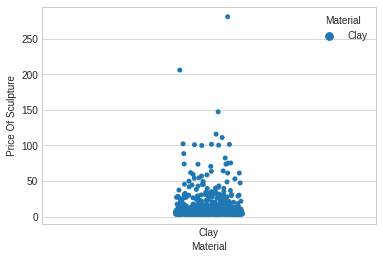

In [ ]:
sns.stripplot(data=raw_train.loc[raw_train['Material'].isin(['Clay'])], x='Material', y='Price Of Sculpture', hue='Material')

In [ ]:
raw_train.loc[~raw_train['Material'].isin(['Marble', 'Stone'])]

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"New Michelle, OH 50777",283.29
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"New Michaelport, WY 12072",159.96
2,fffe3600370035003100,Laura Miller,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,03/09/15,03/08/15,"Bowmanshire, WA 19241",154.29
3,fffe350031003300,Robert Chaires,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,05/24/15,05/20/15,"East Robyn, KY 86375",161.16
4,fffe3900320038003400,Rosalyn Krol,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,12/18/16,12/14/16,"Aprilside, PA 52793",159.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6494,fffe3300370030003500,Karen Bayles,0.45,NaN,28.0,10851.0,Aluminium,30.83,67.70,No,No,Yes,Roadways,No,Working Class,No,04/19/16,04/21/16,"Singletonstad, MD 79303",1076.85
6495,fffe3800370037003300,Jeffrey Freudenthal,0.37,37.0,10.0,16551.0,Brass,28.28,38.46,Yes,Yes,No,Airways,No,Wealthy,Yes,03/28/18,03/25/18,"New Robert, VT 85335",872.43
6496,fffe310036003400,Larry Edwards,0.67,15.0,NaN,18981.0,NaN,67.18,27.72,No,No,No,Roadways,No,Working Class,No,08/29/15,08/27/15,"New Joshua, VA 35766",1347.02
6497,fffe3600300031003300,Denise Worth,0.68,19.0,8.0,587.0,Clay,6.92,10.38,Yes,No,No,NaN,Yes,Wealthy,No,04/10/19,04/09/19,"Lake Kelly, MA 80823",354.55


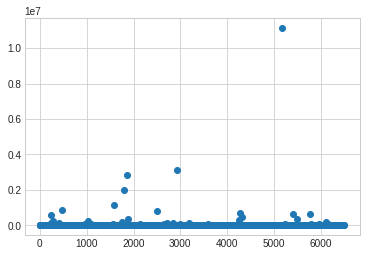

In [ ]:
trans_na = raw_train.loc[raw_train['Transport'].isna(), 'Cost']
# raw_train['Transport']
plt.scatter(trans_na.index, trans_na)

In [ ]:
raw_train['Transport'].isna().sum()

1392

In [ ]:
raw_train.info()
# raw_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer Id            6500 non-null   object 
 1   Artist Name            6500 non-null   object 
 2   Artist Reputation      5750 non-null   float64
 3   Height                 6125 non-null   float64
 4   Width                  5916 non-null   float64
 5   Weight                 5913 non-null   float64
 6   Material               5736 non-null   object 
 7   Price Of Sculpture     6500 non-null   float64
 8   Base Shipping Price    6500 non-null   float64
 9   International          6500 non-null   object 
 10  Express Shipment       6500 non-null   object 
 11  Installation Included  6500 non-null   object 
 12  Transport              5108 non-null   object 
 13  Fragile                6500 non-null   object 
 14  Customer Information   6500 non-null   object 
 15  Remo

In [ ]:
raw_test.isna().sum()

Customer Id                0
Artist Name                0
Artist Reputation        222
Height                   119
Width                    141
Weight                   149
Material                   0
Price Of Sculpture         0
Base Shipping Price        0
International              0
Express Shipment           0
Installation Included      0
Transport                232
Fragile                    0
Customer Information       0
Remote Location            0
Scheduled Date             0
Delivery Date              0
Customer Location          0
dtype: int64

In [ ]:
class CustomCategory(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #Do transformations and return
        return transformed_data

In [ ]:
def get_location()

In [ ]:
test_loc = pd.concat([raw_train.copy(), raw_test.copy()])

test_loc['abbre'] = test_loc['Customer Location'].apply(lambda x: x.split(', ')[-1].split()[0])

test_loc['Scheduled Date'] = pd.to_datetime(test_loc['Scheduled Date'])
test_loc['Delivery Date'] = pd.to_datetime(test_loc['Delivery Date'])
test_loc['diff'] = (test_loc['Delivery Date'] - test_loc['Scheduled Date']).dt.days

test_loc.head()
test_loc.isna().sum()

Customer Id                 0
Artist Name                 0
Artist Reputation         972
Height                    494
Width                     725
Weight                    736
Material                  764
Price Of Sculpture          0
Base Shipping Price         0
International               0
Express Shipment            0
Installation Included       0
Transport                1624
Fragile                     0
Customer Information        0
Remote Location           771
Scheduled Date              0
Delivery Date               0
Customer Location           0
Cost                     3500
abbre                       0
diff                        0
dtype: int64

In [ ]:
imp_num_feat = ['Price Of Sculpture', 'Base Shipping Price', 'diff']
imp_cat_feat = ['International', 'Express Shipment', 'Installation Included', 'Customer Information', 'abbre',]
imp_target = ['Remote Location']

In [ ]:
imp_df = test_loc[imp_num_feat + imp_cat_feat + imp_target]

In [ ]:
imp_df = imp_df.dropna()
print(imp_df.info())
imp_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9229 entries, 0 to 3499
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price Of Sculpture     9229 non-null   float64
 1   Base Shipping Price    9229 non-null   float64
 2   diff                   9229 non-null   int64  
 3   International          9229 non-null   object 
 4   Express Shipment       9229 non-null   object 
 5   Installation Included  9229 non-null   object 
 6   Customer Information   9229 non-null   object 
 7   abbre                  9229 non-null   object 
 8   Remote Location        9229 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 721.0+ KB
None


,Price Of Sculpture,Base Shipping Price,diff,International,Express Shipment,Installation Included,Customer Information,abbre,Remote Location
0,13.91,16.27,-4,Yes,Yes,No,Working Class,OH,No
1,6.83,15.00,-1,No,No,No,Working Class,WY,No
2,4.96,21.18,-1,No,No,No,Working Class,WA,Yes
3,5.81,16.31,-4,No,No,No,Wealthy,KY,Yes
4,3.18,11.94,-4,Yes,Yes,Yes,Working Class,PA,No


In [ ]:
numeric_transformer = Pipeline(steps=[
            ('log', FunctionTransformer(np.log1p)),
            ('scalar', StandardScaler()),
])

In [ ]:
col_transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['Price Of Sculpture', 'Base Shipping Price']),
        ('cat', OrdinalEncoder(), imp_cat_feat),
    ],
    remainder='passthrough',
)

In [ ]:
full_pipeline = Pipeline([
        ('pre', col_transformer),
        ('model', LogisticRegression(C=0.1))        
])

In [ ]:
le = LabelEncoder()
new_y1 = le.fit_transform(y1)
new_y2 = le.transform(y2)
print(new_y1, new_y2)
le.classes_

[1 0 0 ... 0 0 0] [0 0 0 ... 1 1 0]


array(['No', 'Yes'], dtype=object)

In [ ]:
X1, X2, y1, y2 = train_test_split(imp_df.drop(imp_target, axis=1), imp_df[imp_target], test_size=0.2, shuffle=True, stratify=imp_df[imp_target], random_state=24)

In [ ]:
cross_val_score(full_pipeline, X1, y1, scoring='accuracy')

array([0.79959377, 0.79959377, 0.80027082, 0.8001355 , 0.8001355 ])

In [ ]:
cross_val_score(full_pipeline, X1, y1, scoring='accuracy')

array([0.79214624, 0.79282329, 0.79146919, 0.79336043, 0.79945799])

In [ ]:
cross_val_score(full_pipeline, X1, y1, scoring='accuracy')

array([0.79823968, 0.79214624, 0.80094787, 0.79674797, 0.79945799])

In [ ]:
full_pipeline.fit(imp_df.drop(imp_target, axis=1), le.transform(imp_df[imp_target]))

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['Price Of Sculpture',
                                                   'Base Shipping Price']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['International',
                                                   'Express Shipment',
                                                   'Installation Included',
                                                   'Customer Informati

In [ ]:
inp_data = test_loc[imp_num_feat + imp_cat_feat].loc[test_loc['Remote Location'].isna()]
inp_data.shape

(771, 8)

In [ ]:
inp_data

,Price Of Sculpture,Base Shipping Price,diff,International,Express Shipment,Installation Included,Customer Information,abbre
33,4.71,22.24,0,No,No,No,Wealthy,APO
39,4.15,22.03,-1,No,No,No,Working Class,HI
43,3.14,15.04,0,No,No,Yes,Wealthy,AR
48,10.08,19.77,-1,Yes,No,No,Working Class,MS
51,554.72,92.44,0,No,No,Yes,Working Class,FPO
...,...,...,...,...,...,...,...,...
6461,6.11,14.73,0,No,Yes,No,Wealthy,VA
6468,3.82,10.59,-2,No,No,No,Working Class,NY
6478,1625.56,43.79,1,No,No,Yes,Working Class,FPO
6485,11.98,19.19,0,No,Yes,Yes,Wealthy,APO


In [ ]:
rem_loc_preds = full_pipeline.predict(inp_data)

In [ ]:
rem_loc_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
test_loc.groupby(['abbre', 'Remote Location']).agg(['count', 'mean'])[['diff', 'Price Of Sculpture']]

diff           Price Of Sculpture             
                      count      mean              count         mean
abbre Remote Location                                                
AK    No                118 -0.288136                118   454.022458
      Yes                26  0.307692                 26  1655.617308
AL    No                117  0.119658                117   265.128974
      Yes                33 -0.060606                 33  1610.600909
APO   No                268  0.119403                268  1258.470618
...                     ...       ...                ...          ...
WI    Yes                30  0.066667                 30   680.122333
WV    No                129 -0.178295                129  1271.834651
      Yes                30 -0.333333                 30   486.444000
WY    No                125 -0.352000                125  1453.622080
      Yes                41 -0.195122                 41  2478.452439

[108 rows x 4 columns]

In [ ]:
test_loc.corr()

,Artist Reputation,Height,Width,Weight,Price Of Sculpture,Base Shipping Price,Cost,diff
Artist Reputation,1.000000,-0.006079,-0.007920,0.003346,0.047214,-0.012866,0.071991,-0.000774
Height,-0.006079,1.000000,0.769226,0.235398,0.210231,0.353731,0.114737,-0.003949
Width,-0.007920,0.769226,1.000000,0.335268,0.294289,0.331946,0.166999,0.000611
Weight,0.003346,0.235398,0.335268,1.000000,0.866618,0.151779,0.438959,0.008540
Price Of Sculpture,0.047214,0.210231,0.294289,0.866618,1.000000,0.133234,0.491871,0.012536
Base Shipping Price,-0.012866,0.353731,0.331946,0.151779,0.133234,1.000000,0.059591,0.002834
Cost,0.071991,0.114737,0.166999,0.438959,0.491871,0.059591,1.000000,0.014623
diff,-0.000774,-0.003949,0.000611,0.008540,0.012536,0.002834,0.014623,1.000000


In [ ]:
X, y = train_test_split()

In [ ]:

test_loc.head()

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost,abbre
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,2015-06-07,2015-06-03,"New Michelle, OH 50777",283.29,OH
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,2017-03-06,2017-03-05,"New Michaelport, WY 12072",159.96,WY
2,fffe3600370035003100,Laura Miller,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,2015-03-09,2015-03-08,"Bowmanshire, WA 19241",154.29,WA
3,fffe350031003300,Robert Chaires,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,2015-05-24,2015-05-20,"East Robyn, KY 86375",161.16,KY
4,fffe3900320038003400,Rosalyn Krol,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,2016-12-18,2016-12-14,"Aprilside, PA 52793",159.23,PA


In [ ]:

test_loc.head()

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost,abbre,diff
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,2015-06-07,2015-06-03,"New Michelle, OH 50777",283.29,OH,-4
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,2017-03-06,2017-03-05,"New Michaelport, WY 12072",159.96,WY,-1
2,fffe3600370035003100,Laura Miller,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,2015-03-09,2015-03-08,"Bowmanshire, WA 19241",154.29,WA,-1
3,fffe350031003300,Robert Chaires,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,2015-05-24,2015-05-20,"East Robyn, KY 86375",161.16,KY,-4
4,fffe3900320038003400,Rosalyn Krol,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,2016-12-18,2016-12-14,"Aprilside, PA 52793",159.23,PA,-4


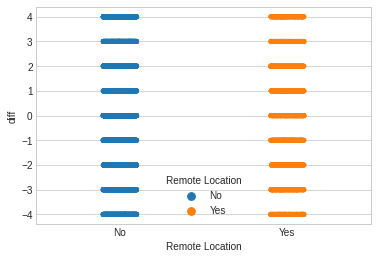

In [ ]:
sns.stripplot(data=test_loc, x='Remote Location', y='diff', hue='Remote Location')

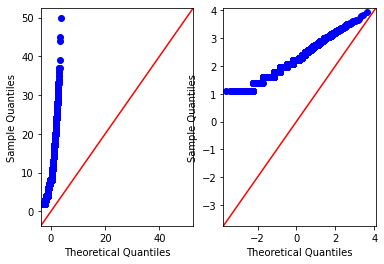

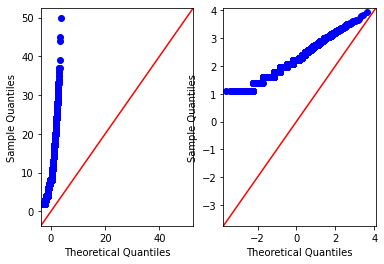

In [ ]:
fig, ax = plt.subplots(ncols=2)

sm.qqplot(raw_train['Width'].fillna(raw_train['Width'].median()), line='45', ax=ax[0])
data = np.log1p(raw_train['Width'].fillna(method='bfill'))
sm.qqplot(data, line='45', ax=ax[1])

In [ ]:
skewness = raw_train.select_dtypes(include=['float64']).fillna(method='ffill').skew().sort_values(ascending=False)
skewness

Cost                   29.866406
Price Of Sculpture     22.206823
Weight                 20.753595
Width                   1.537908
Base Shipping Price     0.918102
Height                  0.599241
Artist Reputation       0.140284
dtype: float64

In [ ]:
eda = raw_train.fillna(method='ffill').copy()

In [ ]:
eda[['Cost', 'Price Of Sculpture', 'Weight']] = eda[['Cost', 'Price Of Sculpture', 'Weight']].apply(np.log).apply(np.sqrt)

In [ ]:
skewness = eda.select_dtypes(include=['float64']).fillna(method='ffill').skew().sort_values(ascending=False)
skewness

Width                  1.537908
Cost                   1.392428
Price Of Sculpture     0.931665
Base Shipping Price    0.918102
Height                 0.599241
Artist Reputation      0.140284
Weight                 0.080709
dtype: float64

In [ ]:
raw_train

In [ ]:
raw_train.head()

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"New Michelle, OH 50777",283.29
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"New Michaelport, WY 12072",159.96
2,fffe3600370035003100,Laura Miller,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,03/09/15,03/08/15,"Bowmanshire, WA 19241",154.29
3,fffe350031003300,Robert Chaires,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,05/24/15,05/20/15,"East Robyn, KY 86375",161.16
4,fffe3900320038003400,Rosalyn Krol,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,12/18/16,12/14/16,"Aprilside, PA 52793",159.23


In [ ]:
date_df = raw_train[['Scheduled Date', 'Delivery Date', 'Cost']]
date_df.columns = ['sd', 'dd', 'cost']
date_df.head()

,sd,dd,cost
0,06/07/15,06/03/15,5.649995
1,03/06/17,03/05/17,5.081156
2,03/09/15,03/08/15,5.045294
3,05/24/15,05/20/15,5.088584
4,12/18/16,12/14/16,5.076610


In [ ]:
date_df['sd'] = pd.to_datetime(date_df['sd'])
date_df['dd'] = pd.to_datetime(date_df['dd'])
date_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,sd,dd,cost
0,2015-06-07,2015-06-03,5.649995
1,2017-03-06,2017-03-05,5.081156
2,2015-03-09,2015-03-08,5.045294
3,2015-05-24,2015-05-20,5.088584
4,2016-12-18,2016-12-14,5.076610


In [ ]:
date_df['diff'] = (date_df['dd'] - date_df['sd'])
date_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,sd,dd,cost,diff
0,2015-06-07,2015-06-03,5.649995,-4 days
1,2017-03-06,2017-03-05,5.081156,-1 days
2,2015-03-09,2015-03-08,5.045294,-1 days
3,2015-05-24,2015-05-20,5.088584,-4 days
4,2016-12-18,2016-12-14,5.076610,-4 days
...,...,...,...,...
6495,2018-03-28,2018-03-25,6.772428,-3 days
6496,2015-08-29,2015-08-27,7.206392,-2 days
6497,2019-04-10,2019-04-09,5.873666,-1 days
6498,2019-03-10,2019-03-12,8.524864,2 days


In [ ]:
date_df['diff'] = date_df['diff'].apply(lambda x: x.days)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
date_df['sdm'] = date_df['sd'].apply(lambda x: x.month)
date_df['sdy'] = date_df['sd'].apply(lambda x: x.year)

In [ ]:
date_df.sample(10)
date_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6498 entries, 0 to 6499
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   sd      6498 non-null   datetime64[ns]
 1   dd      6498 non-null   datetime64[ns]
 2   cost    6498 non-null   float64       
 3   diff    6498 non-null   int64         
 4   sdm     6498 non-null   int64         
 5   sdy     6498 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(3)
memory usage: 675.4 KB


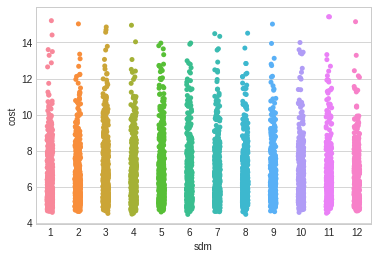

In [ ]:
sns.stripplot(data=date_df, x='sdm', y='cost')
plt.show()

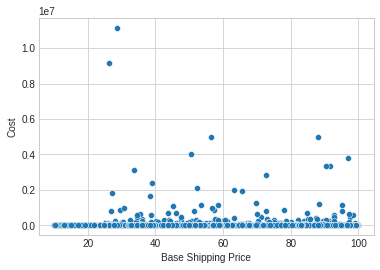

In [ ]:
sns.scatterplot(data=raw_train, x='Base Shipping Price', y='Cost')

In [ ]:
date_df.corr()

,cost,diff
cost,1.000000,-0.023512
diff,-0.023512,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



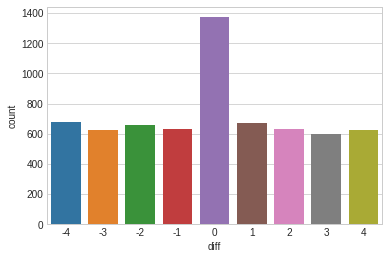

In [ ]:
# sns.displot(data=raw_train, x='Price Of Sculpture')
# plt.show()

sns.countplot(date_df['diff'])
# plt.plot(raw_test['Price Of Sculpture'])

In [ ]:
raw_train.loc[raw_train['Price Of Sculpture'] > 200000]

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
1860,fffe3400340033003800,Patricia Smith,NaN,47.0,32.0,47544217.0,Stone,230578.77,72.83,No,Yes,Yes,NaN,No,Working Class,Yes,03/10/15,03/10/15,"Holmesborough, TN 18612",14.855503
2731,fffe320032003000,Bessie Cordero,NaN,NaN,21.0,25254560.0,Stone,231660.46,91.48,No,Yes,No,Roadways,No,Wealthy,No,09/14/18,09/14/18,"Port Scott, MI 75422",15.016941
6133,fffe3800330034003300,Charles Palos,0.68,52.0,45.0,117927869.0,Stone,382385.67,38.89,No,No,Yes,Airways,No,Working Class,No,03/15/17,03/16/17,"Morrisshire, HI 99807",14.697647


In [ ]:
raw_train.loc[raw_train['Weight'] > 100000000]

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
6133,fffe3800330034003300,Charles Palos,0.68,52.0,45.0,117927869.0,Stone,382385.67,38.89,No,No,Yes,Airways,No,Working Class,No,03/15/17,03/16/17,"Morrisshire, HI 99807",14.697647


In [ ]:
date_df = date_df[date_df.loc[:, 'cost'] <= 0.4]
date_df.shape

(0, 4)

In [ ]:
sorted = raw_train.sort_values('Cost', ascending=False)
sorted

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
5164,fffe3300390037003100,George Carn,0.95,41.0,26.0,24039379.0,Stone,51410.27,28.73,Yes,Yes,No,NaN,No,Working Class,No,06/06/17,06/10/17,"Branditown, MT 66369",11143428.25
4431,fffe3200300032003700,Allen Thayer,0.87,28.0,16.0,4250532.0,NaN,9108.78,26.27,No,Yes,Yes,Airways,No,Working Class,No,04/28/15,04/28/15,"Lake Johnview, ID 88562",9177540.38
2772,fffe3300340036003800,Eric Howard,0.71,40.0,25.0,19453774.0,NaN,88827.64,87.93,No,No,Yes,Airways,No,Wealthy,No,11/26/17,11/24/17,"Brewerberg, MN 03238",4992890.84
4787,fffe3100380037003200,Rosario Nicklas,0.65,NaN,23.0,NaN,Stone,98670.21,56.57,No,No,Yes,Roadways,No,Working Class,No,11/20/15,11/23/15,"Michaelside, CT 21533",4976100.89
4560,fffe3800340039003500,John Carroll,0.77,55.0,27.0,13817875.0,Marble,76786.57,50.52,No,No,Yes,Roadways,Yes,Working Class,No,01/29/18,01/26/18,"Port Julia, OH 16359",4020731.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3554,fffe3300320037003400,Patricia Passarelli,0.03,21.0,9.0,725.0,Aluminium,3.36,10.64,No,No,No,Roadways,No,Working Class,No,04/14/15,04/16/15,"Andrewhaven, OK 23764",92.05
5562,fffe3800330037003600,Margo Brown,0.09,4.0,4.0,35.0,Wood,3.52,11.33,No,No,No,Roadways,No,Working Class,No,03/06/17,03/06/17,DPO AA 15050,90.94
3080,fffe3700300031003100,Leonard Whalen,0.04,24.0,10.0,342.0,Wood,3.56,11.48,No,Yes,No,Roadways,No,Working Class,No,04/24/16,04/28/16,"Piercefurt, NJ 60074",87.56
594,fffe3400350033003800,Ruby Legra,0.06,28.0,13.0,521.0,Wood,3.64,10.88,Yes,No,No,Waterways,No,Working Class,No,08/20/17,08/24/17,"Lindseyport, FL 56287",86.39


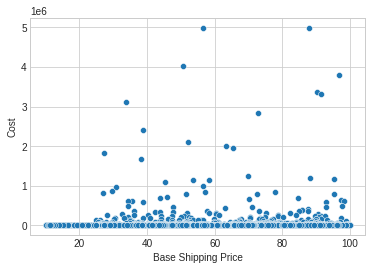

In [ ]:
sns.scatterplot(data=sorted.iloc[2:, :], x='Base Shipping Price', y='Cost')

# Preprocess

In [ ]:
def material_imputer(df):
    def fill_val(x):
        if x['Material'] in ['Brass', 'Clay', 'Aluminium', 'Wood', 'Marble', 'Bronze', 'Stone']:
            return x['Material']
        else:
            price = x['Price Of Sculpture']
            if x['Fragile'] == 'Yes':
                if price < 500:
                    return 'Clay'
                else:
                    return 'Marble'
            else:
                if price < 8:
                    return 'Wood'
                elif price < 80:
                    return 'Aluminium'
                elif price < 1000:
                    return 'Bronze'
                elif price < 2100:
                    return 'Brass'
                elif price < 50000:
                    return 'Marble'
                else:
                    return 'Stone'
                
    dfc = df.copy()
    dfc['Material'] = dfc.apply(lambda x: fill_val(x), axis=1)
    return dfc

In [ ]:
def transport_imputer(df):
    def fill_val(x):
        if x['Transport'] not in ['Airways', 'Roadways', 'Waterways']:
            if x['Express Shipment'] == "No":
                if x['International'] == "No":
                    return "Roadways"
                else:
                    return "Waterways"
            else:
                if x['International'] == 'No':
                    if x['Price Of Sculpture'] > 1000:
                        return 'Roadways'
                    else:
                        return 'Airways'

                else:
                    return 'Airways'

        else:
            return x['Transport']

    dfc = df.copy()
    dfc['Transport'] = dfc.apply(lambda x: fill_val(x), axis=1)
    return dfc

In [ ]:
def del_cols(dataframe):
    remove_cols = ['Customer Id', 'Artist Name', 'Customer Location']
    dataframe = dataframe.drop(remove_cols, axis=1)

    return dataframe

In [ ]:
def get_date_diff(dataframe):
    dataframe['Scheduled Date'] = pd.to_datetime(dataframe['Scheduled Date'])
    dataframe['Delivery Date'] = pd.to_datetime(dataframe['Delivery Date'])
    
    dataframe['Diff'] = (dataframe['Scheduled Date'] - dataframe['Delivery Date']).dt.days
    dataframe = dataframe.drop(['Scheduled Date', 'Delivery Date'], axis=1)

    return dataframe 

In [ ]:
X = df_train.drop('Cost', axis=1)
y = df_train['Cost']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2407)

In [ ]:
X_train.head()

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Scheduled Date,Delivery Date,Customer Location
1908,fffe3300320032003600,Angela Beadle,0.91,34.0,11.0,2261.0,Clay,8.31,20.13,No,No,Yes,Roadways,Yes,Working Class,12/04/15,12/06/15,"South Gloria, WV 03145"
1824,fffe3900340031003100,Wanda Nichols,0.29,28.0,11.0,1082957.0,Stone,4029.79,54.61,No,No,No,Roadways,No,Working Class,02/18/19,02/19/19,"Port Shannon, LA 53329"
2530,fffe3500310032003600,Ronald Drumheller,1.00,17.0,7.0,168042.0,Stone,562.35,54.81,No,No,Yes,Airways,No,Wealthy,09/29/17,09/26/17,"East Heather, TX 64755"
5719,fffe3100370037003000,Daniel Jefferson,0.85,19.0,17.0,1592885.0,Stone,14443.34,66.49,No,No,Yes,Airways,No,Working Class,03/13/17,03/10/17,"Michelleshire, AR 26546"
3693,fffe3700320034003100,Alexander Mullins,0.81,19.0,7.0,2535.0,Bronze,9.23,22.87,No,Yes,Yes,Airways,No,Working Class,07/28/16,08/01/16,"Blackwellview, WV 26139"


In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5197, 18) (5197,) (1300, 18) (1300,)


In [ ]:
num_features = ['Artist Reputation', 'Height', 'Width', 'Weight', 'Price Of Sculpture', 'Base Shipping Price',]
cat_features = ['Material', 'Transport']
zero_one_features = ['International', 'Express Shipment', 'Installation Included', 
                     'Customer Information', 'Fragile']
cat_features = cat_features + zero_one_features

# Catboost

In [ ]:
# replacing nan in categorical columns to empty string to avoid catboost error
df[cat_cols] = df[cat_cols].replace(np.nan, '')
df[cat_cols] = df[cat_cols].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Artist Reputation      5750 non-null   float64 
 1   Height                 6125 non-null   float64 
 2   Width                  5916 non-null   float64 
 3   Weight                 5913 non-null   float64 
 4   Material               6500 non-null   category
 5   Price Of Sculpture     6500 non-null   float64 
 6   Base Shipping Price    6500 non-null   float64 
 7   International          6500 non-null   category
 8   Express Shipment       6500 non-null   category
 9   Installation Included  6500 non-null   category
 10  Transport              6500 non-null   category
 11  Fragile                6500 non-null   category
 12  Customer Information   6500 non-null   category
 13  Remote Location        6500 non-null   category
 14  Cost                   6500 non-null   f

In [ ]:
df.head()

,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Cost
0,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,283.29
1,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,159.96
2,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,154.29
3,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,,No,Wealthy,Yes,161.16
4,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,159.23


In [ ]:
df.describe()

,Artist Reputation,Height,Width,Weight,Price Of Sculpture,Base Shipping Price,Cost
count,5750.000000,6125.000000,5916.000000,5.913000e+03,6500.00000,6500.000000,6.500000e+03
mean,0.461850,21.766204,9.617647,4.006948e+05,1192.42009,37.407174,1.883983e+04
std,0.265781,11.968192,5.417000,2.678081e+06,8819.61675,26.873519,2.405307e+05
min,0.000000,3.000000,2.000000,3.000000e+00,3.00000,10.000000,8.607000e+01
25%,0.240000,12.000000,6.000000,5.030000e+02,5.23000,16.700000,2.267950e+02
50%,0.450000,20.000000,8.000000,3.102000e+03,8.02500,23.505000,4.581550e+02
75%,0.680000,30.000000,12.000000,3.645600e+04,89.47000,57.905000,1.366273e+03
max,1.000000,73.000000,50.000000,1.179279e+08,382385.67000,99.980000,1.114343e+07


In [ ]:
cbr = cat.CatBoostRegressor(iterations=75000)

In [ ]:
cbr.fit(X, y, cat_features=cat_cols.values)

Streaming output truncated to the last 5000 lines.
70000:	learn: 1754.6466948	total: 8m 45s	remaining: 37.5s
70001:	learn: 1754.6307856	total: 8m 45s	remaining: 37.5s
70002:	learn: 1754.6084972	total: 8m 45s	remaining: 37.5s
70003:	learn: 1754.5837824	total: 8m 45s	remaining: 37.5s
70004:	learn: 1754.5030320	total: 8m 45s	remaining: 37.5s
70005:	learn: 1754.4436355	total: 8m 45s	remaining: 37.5s
70006:	learn: 1754.3844232	total: 8m 45s	remaining: 37.5s
70007:	learn: 1754.3564179	total: 8m 45s	remaining: 37.5s
70008:	learn: 1754.3505357	total: 8m 45s	remaining: 37.4s
70009:	learn: 1754.3213279	total: 8m 45s	remaining: 37.4s
70010:	learn: 1754.2640813	total: 8m 45s	remaining: 37.4s
70011:	learn: 1754.2471511	total: 8m 45s	remaining: 37.4s
70012:	learn: 1754.2063396	total: 8m 45s	remaining: 37.4s
70013:	learn: 1754.1683637	total: 8m 45s	remaining: 37.4s
70014:	learn: 1754.1518493	total: 8m 45s	remaining: 37.4s
70015:	learn: 1754.1213386	total: 8m 45s	remaining: 37.4s
70016:	learn: 1754.11

In [ ]:
raw_test = pd.read_csv('/content/dataset/test.csv')
raw_sub = pd.read_csv('/content/dataset/sample_submission.csv')

In [ ]:
# prepare test data
df_test = raw_test.drop(remove, axis=1)

df_test[cat_cols] = df_test[cat_cols].replace(np.nan, '')
df_test[cat_cols] = df_test[cat_cols].astype('category')

In [ ]:
preds = cbr.predict(df_test)
preds = np.abs(preds)

In [ ]:
preds.shape

(3500,)

In [ ]:
raw_sub.head()

,Customer Id,Cost
0,fffe3900350033003300,283.29
1,fffe3800330031003900,159.96
2,fffe3600370035003100,154.29
3,fffe350031003300,161.16
4,fffe3900320038003400,159.23


In [ ]:
sub = pd.DataFrame({'Customer Id': raw_test['Customer Id'].values, 'Cost': preds})
sub.head()

,Customer Id,Cost
0,fffe3400310033003300,1703.416487
1,fffe3600350035003400,569.398850
2,fffe3700360030003500,185.464377
3,fffe350038003600,47.576573
4,fffe3500390032003500,1348.597490


In [ ]:
sub.loc[sub['Cost'] < 0]

,Customer Id,Cost


In [ ]:
sub.to_csv('catboost_default_mod.csv', index=False)

In [ ]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer Id  3500 non-null   object 
 1   Cost         3500 non-null   float64
dtypes: float64(1), object(1)
memory usage: 54.8+ KB


In [ ]:
df['Cost'].plot(kind='scatter')

# Pipelines

In [ ]:
numeric_transformer = Pipeline(steps=[
            ('num_imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p)),
            ('scalar', StandardScaler()),
])

In [ ]:
# categorical_transformer = Pipeline([
#             ('cat_imputer', SimpleImputer(strategy='most-frequent', fill_value='missing')),
#             ('oh_encoder', OneHotEncoder())
# ])

In [ ]:
col_transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        # ('cat', OneHotEncoder(), cat_features),
        ('zo', OrdinalEncoder(), cat_features),
    ],
    remainder='passthrough',
)

In [ ]:
full_pipeline = Pipeline([
        ('del_col', FunctionTransformer(del_cols)),
        ('get_date_diff', FunctionTransformer(get_date_diff)),
        ('trans_imp', FunctionTransformer(transport_imputer)),
        ('mat_imp', FunctionTransformer(material_imputer)),
        ('pre', col_transformer),        
])

In [ ]:
full_pipeline.fit_transform(X_train, y_train).shape

(5197, 15)

In [ ]:
class MyTransformedTargetRegressor(TransformedTargetRegressor):
    @property
    def feature_importances_(self):
        return self.regressor_.feature_importances_

In [ ]:
regressor = GradientBoostingRegressor(
    n_estimators=261,
    max_depth=7,
    learning_rate=0.065
)
# regressor = DecisionTreeRegressor(max_depth=4)
model = MyTransformedTargetRegressor(regressor=regressor, transformer=QuantileTransformer(output_distribution='normal'))

In [ ]:
classifier = Pipeline(steps=[
                    ('preprocess', full_pipeline),
                    ('model', model),
])

In [ ]:
scores = cross_val_score(classifier, X, y, cv=5, scoring='neg_mean_squared_log_error', n_jobs=-1,)
print(scores)
print(f'Mean Score: {(1 + scores.mean()) * 100:.4f}')

[-0.08635755 -0.08411378 -0.07815567 -0.07744913 -0.06606747]
Mean Score: 92.1571


In [ ]:
classifier.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocess',
                 Pipeline(memory=None,
                          steps=[('del_col',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<function del_cols at 0x7f7f5774fdd0>,
                                                      inv_kw_args=None,
                                                      inverse_func=None,
                                                      kw_args=None,
                                                      validate=False)),
                                 ('get_date_diff',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<function get_date_diff at...
                                          

In [ ]:
classifier.named_steps['model'].feature_importances_

array([0.17219153, 0.01124391, 0.00516136, 0.03053966, 0.32659595,
       0.42281159, 0.0061213 , 0.00314552, 0.00132659, 0.00392924,
       0.00409701, 0.00358572, 0.000528  , 0.00872262])

In [ ]:
x_label = ['Artist Reputation', 'Height', 'Width',
       'Weight', 'Material', 'Price Of Sculpture', 'Base Shipping Price',
       'International', 'Express Shipment', 'Installation Included',
       'Transport', 'Fragile', 'Customer Information','Diff']
len(x_label)

14

<BarContainer object of 14 artists>

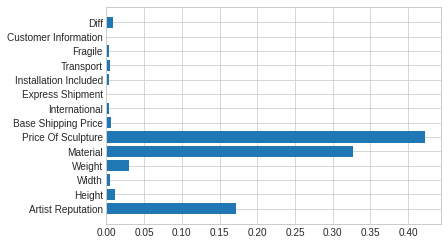

In [ ]:
plt.barh(x_label, classifier.named_steps['model'].feature_importances_)

In [ ]:
df_train.columns

Index(['Customer Id', 'Artist Name', 'Artist Reputation', 'Height', 'Width',
       'Weight', 'Material', 'Price Of Sculpture', 'Base Shipping Price',
       'International', 'Express Shipment', 'Installation Included',
       'Transport', 'Fragile', 'Customer Information', 'Remote Location',
       'Scheduled Date', 'Delivery Date', 'Customer Location', 'Cost'],
      dtype='object')

# optuna

In [ ]:
def lgbm_objective(trial):

    param = {
        'num_iterations': 1000,
        'n_estimators': trial.suggest_int('n_estimators', 34000, 40000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.1, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 0.1),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0]),
        'learning_rate': 0.1,
        # 'learning_rate': trial.suggest_categorical('learning_rate', [0.006, 0.008, 0.01, 0.014, 0.017, 0.02, 0.1, 0.5]),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'num_leaves' : trial.suggest_int('num_leaves', 400, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
    }

    regressor_obj = lgb.LGBMRegressor(**param)

    model = MyTransformedTargetRegressor(
        regressor=regressor_obj, 
        transformer=QuantileTransformer(output_distribution='normal')
    )
    classifier = Pipeline(steps=[
                    ('preprocess', full_pipeline),
                    ('model', model),
    ])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    classifier.fit(X_train, y_train)
    
    y_preds = classifier.predict(X_test)
    error = mean_squared_log_error(y_test, y_preds)
    return error

lgbm_study = optuna.create_study()  # Create a new study.
lgbm_study.optimize(lgbm_objective, n_trials=100) 

[I 2021-03-05 13:35:26,350] A new study created in memory with name: no-name-2a95169c-5b8b-4983-a6d6-9d540e7f1c25
[I 2021-03-05 13:35:28,494] Trial 0 finished with value: 0.08899204795413136 and parameters: {'n_estimators': 38413, 'reg_alpha': 1.4193526455966103, 'reg_lambda': 0.011383394669101909, 'colsample_bytree': 0.9, 'subsample': 0.7, 'max_depth': 7, 'num_leaves': 488, 'min_child_samples': 24}. Best is trial 0 with value: 0.08899204795413136.
[I 2021-03-05 13:35:32,232] Trial 1 finished with value: 0.11812107902475459 and parameters: {'n_estimators': 35578, 'reg_alpha': 0.1316456509783578, 'reg_lambda': 0.007551865293723582, 'colsample_bytree': 0.8, 'subsample': 1.0, 'max_depth': 10, 'num_leaves': 429, 'min_child_samples': 11}. Best is trial 0 with value: 0.08899204795413136.
[I 2021-03-05 13:35:34,339] Trial 2 finished with value: 0.0897185759880317 and parameters: {'n_estimators': 34038, 'reg_alpha': 1.2059821055745985, 'reg_lambda': 0.012610747111751905, 'colsample_bytree': 1.

In [ ]:
optuna.visualization.plot_parallel_coordinate(lgbm_study, lgbm_study.best_params.keys())

In [ ]:
def xgb_objective(trial):

    param = {
        'n_estimators': trial.suggest_int('n_estimators', 800, 1800),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.1, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.05, 1.5),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.8, 0.9, 1.0]),
        'eta': trial.suggest_uniform('eta', 0.01, 0.07),
        'max_depth': trial.suggest_int('max_depth', 5, 9),
    }

    regressor_obj = xgb.XGBRegressor(**param)

    model = TransformedTargetRegressor(
        regressor=regressor_obj, 
        transformer=QuantileTransformer(output_distribution='normal')
    )
    classifier = Pipeline(steps=[
                    ('preprocess', full_pipeline),
                    ('model', model),
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    classifier.fit(X_train, y_train)
    
    y_preds = classifier.predict(X_test)
    error = mean_squared_log_error(y_test, y_preds)
    return error

xgb_study = optuna.create_study()  # Create a new study.
xgb_study.optimize(xgb_objective, n_trials=50) 

[I 2021-03-05 12:02:04,125] A new study created in memory with name: no-name-5e89ed1d-9b67-41c3-8512-c10e4ad8325e
[I 2021-03-05 12:02:13,474] Trial 0 finished with value: 0.0733461796671232 and parameters: {'n_estimators': 1346, 'reg_alpha': 0.6241665508628365, 'reg_lambda': 0.10327472978714371, 'colsample_bytree': 0.8, 'subsample': 0.9, 'eta': 0.06678015138300068, 'max_depth': 6}. Best is trial 0 with value: 0.0733461796671232.
[I 2021-03-05 12:02:19,629] Trial 1 finished with value: 0.09059222472267406 and parameters: {'n_estimators': 1335, 'reg_alpha': 0.17990970569627213, 'reg_lambda': 1.2922657939426518, 'colsample_bytree': 0.3, 'subsample': 0.9, 'eta': 0.04142367169287211, 'max_depth': 7}. Best is trial 0 with value: 0.0733461796671232.
[I 2021-03-05 12:02:27,589] Trial 2 finished with value: 0.07955707164277724 and parameters: {'n_estimators': 956, 'reg_alpha': 0.25549775326399443, 'reg_lambda': 1.0560938274896905, 'colsample_bytree': 1.0, 'subsample': 0.8, 'eta': 0.059778190676

In [ ]:
optuna.visualization.plot_parallel_coordinate(xgb_study, params=xgb_study.best_params.keys())

In [ ]:
params = lgbm_study.best_params
regressor_obj = lgb.LGBMRegressor(**params)
# param = xgb_study.best_params
# regressor_obj = xgb.XGBRegressor(**param)

model = MyTransformedTargetRegressor(
    regressor=regressor_obj, 
    transformer=QuantileTransformer(output_distribution='normal')
)
classifier = Pipeline(steps=[
                ('preprocess', full_pipeline),
                ('model', model),
])
scores = cross_val_score(classifier, X, y, scoring='neg_mean_squared_log_error', n_jobs=-1)
print(scores)
(1 + np.mean(scores)) * 100

[-0.106368   -0.08702684 -0.10671296 -0.09449582 -0.08189065]


90.47011467562763

In [ ]:
def gb_objective(trial):

    param = {
        'n_estimators': trial.suggest_int('n_estimators', 250, 1500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        # 'min_samples_split': trial.suggest_uniform('min_samples_split', 0.0, 1.0),
        # 'min_samples_leaf': trial.suggest_uniform('min_samples_leaf', 0.0, 0.5),
        # 'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5),
    }

    regressor_obj = GradientBoostingRegressor(**param)
    model = TransformedTargetRegressor(
        regressor=regressor_obj, 
        transformer=QuantileTransformer(output_distribution='normal')
    )
    
    classifier = Pipeline(steps=[
                    ('preprocess', full_pipeline),
                    ('model', model),
    ])
    # scores = cross_val_score(classifier, X, y, scoring='neg_mean_squared_log_error', n_jobs=-1)
    # return abs(np.mean(scores))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    classifier.fit(X_train, y_train)
    
    y_preds = classifier.predict(X_test)
    error = mean_squared_log_error(y_test, y_preds)
    return error

gb_study = optuna.create_study()  # Create a new study.
gb_study.optimize(gb_objective, n_trials=100) 

[I 2021-03-05 12:29:38,821] A new study created in memory with name: no-name-c8a88213-d1e9-4288-906f-06a48a0537b3
[I 2021-03-05 12:29:53,192] Trial 0 finished with value: 1.4197171777469257 and parameters: {'n_estimators': 1021, 'learning_rate': 0.0005443315999270712, 'max_depth': 4}. Best is trial 0 with value: 1.4197171777469257.
[I 2021-03-05 12:29:59,190] Trial 1 finished with value: 0.5503404244061437 and parameters: {'n_estimators': 308, 'learning_rate': 0.0038618327583051296, 'max_depth': 5}. Best is trial 1 with value: 0.5503404244061437.
[I 2021-03-05 12:30:08,325] Trial 2 finished with value: 0.18139571738858637 and parameters: {'n_estimators': 1273, 'learning_rate': 0.8393201114605546, 'max_depth': 6}. Best is trial 2 with value: 0.18139571738858637.
[I 2021-03-05 12:30:19,591] Trial 3 finished with value: 0.09758434058226591 and parameters: {'n_estimators': 1073, 'learning_rate': 0.3336355296901628, 'max_depth': 8}. Best is trial 3 with value: 0.09758434058226591.
[I 2021-0

KeyboardInterrupt: ignored

In [ ]:
optuna.visualization.plot_parallel_coordinate(gb_study, params=
                                              ['n_estimators', 'max_depth', 'learning_rate', 'output_distribution'])

In [ ]:
params = {'n_estimators': 956, 'learning_rate': 0.03906956158364998, 'max_depth': 5,}
regressor_obj = GradientBoostingRegressor(**params)

model = TransformedTargetRegressor(
    regressor=regressor_obj, 
    transformer=QuantileTransformer(output_distribution='normal')
)
classifier = Pipeline(steps=[
                ('preprocess', full_pipeline),
                ('model', model),
])
scores = cross_val_score(classifier, X, y, scoring='neg_mean_squared_log_error', n_jobs=-1)
print(scores)
(1 + np.mean(scores)) * 100

[-0.09138204 -0.08431687 -0.07096181 -0.07343576 -0.06814745]


92.23512145324729

In [ ]:
# joblib.dump(gb_study, "gb_study.pkl")
joblib.dump(lgbm_study, "lgbm_study.pkl")

['lgbm_study.pkl']

In [ ]:
joblib.dump(rf_study, 'rf_study.pkl')

['rf_study.pkl']

# grid search

In [ ]:
param_grid = {
    'model__regressor__n_estimators': [250, 500],
    'model__regressor__eta': [0.3, 0.5, 0.7],
    'model__regressor__max_depth': [5, 6, 7],
}
grid_cv = GridSearchCV(classifier, param_grid=param_grid, scoring='neg_mean_squared_log_error', n_jobs=-1, refit=True, verbose=3, return_train_score=True)

In [ ]:
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 25.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('del_col',
                                        FunctionTransformer(accept_sparse=False,
                                                            check_inverse=True,
                                                            func=<function del_cols at 0x7f2eca33e0e0>,
                                                            inv_kw_args=None,
                                                            inverse_func=None,
                                                            kw_args=None,
                                                            validate=False)),
                                       ('pre',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                 

In [ ]:
grid_cv.best_estimator_.get_params()

{'del_col': FunctionTransformer(accept_sparse=False, check_inverse=True,
                     func=<function del_cols at 0x7f2eca33e0e0>,
                     inv_kw_args=None, inverse_func=None, kw_args=None,
                     validate=False),
 'del_col__accept_sparse': False,
 'del_col__check_inverse': True,
 'del_col__func': <function __main__.del_cols>,
 'del_col__inv_kw_args': None,
 'del_col__inverse_func': None,
 'del_col__kw_args': None,
 'del_col__validate': False,
 'memory': None,
 'model': TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
                            regressor=XGBRegressor(base_score=None, booster=None,
                                                   colsample_bylevel=None,
                                                   colsample_bynode=None,
                                                   colsample_bytree=None,
                                                   eta=0.3, gamma=None,
                                     

In [ ]:
grid_cv.score(X_test, y_test)

-0.08658713631173161

# cross_val

[-0.11992086 -0.1212499  -0.11704718 -0.12150706 -0.10313673]
-0.11657234574668822


In [ ]:
# y_preds = classifier.predict(X_test)
y_preds = grid_cv.predict(X_test)

pred_check = [1 if x > 0 else 0 for x in y_preds]

if all(pred_check):
    print('All predictions good!')
else:
    print(f'{len(pred_check) - sum(pred_check)} Error in predictions')
    y_preds = [abs(x) for x in y_preds]

All predictions good!


In [ ]:
error = mean_squared_log_error(y_test, y_preds)
print(f'Error: {error:.5f}')
print(f'Score: {(1 - error) * 100:.3f} %')

Error: 0.08659
Score: 91.341 %


In [ ]:
classifier.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocess',
                 Pipeline(memory=None,
                          steps=[('del_col',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<function del_cols at 0x7f7f5f2cc4d0>,
                                                      inv_kw_args=None,
                                                      inverse_func=None,
                                                      kw_args=None,
                                                      validate=False)),
                                 ('get_date_diff',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<function get_date_diff at...
                                          

In [ ]:
# y_preds = grid_cv.predict(raw_test)
y_preds = classifier.predict(raw_test)

In [ ]:
sub = pd.DataFrame({'Customer Id': raw_test['Customer Id'].values, 'Cost': y_preds})
sub.head()

,Customer Id,Cost
0,fffe3400310033003300,210.562332
1,fffe3600350035003400,275.918274
2,fffe3700360030003500,182.394897
3,fffe350038003600,187.796738
4,fffe3500390032003500,348.641144


In [ ]:
file_name = 'xgb_with_custom_imputer_label_enc.csv'
sub.to_csv(file_name, index=False)

In [ ]:
raw_test['Cost'] = y_preds

In [ ]:
full_data = pd.concat([X, raw_test])
full_data.drop('Remote Location', axis=1, inplace=True)
full_data.shape

(9997, 18)

In [ ]:
full_data.isna().sum()

Customer Id                 0
Artist Name                 0
Artist Reputation         972
Height                    494
Width                     725
Weight                    736
Material                  763
Price Of Sculpture          0
Base Shipping Price         0
International               0
Express Shipment            0
Installation Included       0
Transport                1623
Fragile                     0
Customer Information        0
Scheduled Date              0
Delivery Date               0
Customer Location           0
dtype: int64

In [ ]:
py_preds = pd.read_csv('/content/xgb_with_custom_imputer_label_enc_pseudo2.csv').Cost.values

In [ ]:
full_label = np.append(y.values, py_preds)
full_label.shape

(9997,)

In [ ]:
scores = cross_val_score(classifier, full_data, full_label, scoring='neg_mean_squared_log_error')
print(scores)
print(f'Mean Score: {(1 + scores.mean()) * 100:.4f}')

[-0.06782129 -0.05912911 -0.06550479 -0.0120426  -0.00585211]
Mean Score: 95.7930


In [ ]:
full_data.shape

(10000, 20)

In [ ]:
classifier.fit(full_data, full_label)

Pipeline(memory=None,
         steps=[('preprocess',
                 Pipeline(memory=None,
                          steps=[('del_col',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<function del_cols at 0x7f7f5774fdd0>,
                                                      inv_kw_args=None,
                                                      inverse_func=None,
                                                      kw_args=None,
                                                      validate=False)),
                                 ('get_date_diff',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<function get_date_diff at...
                                          

In [ ]:
x_label = ['Artist Reputation', 'Height', 'Width',
       'Weight', 'Material', 'Price Of Sculpture', 'Base Shipping Price',
       'International', 'Express Shipment', 'Installation Included',
       'Transport', 'Fragile', 'Customer Information','Diff']
len(x_label)

14

<BarContainer object of 14 artists>

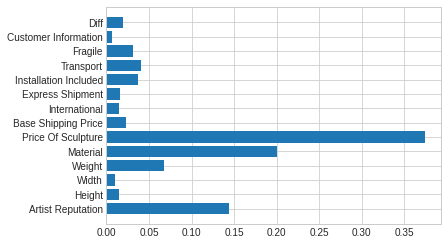

In [ ]:
plt.barh(x_label, classifier.named_steps['model'].feature_importances_)

In [ ]:
pseudo_preds = classifier.predict(raw_test.drop('Remote Location', axis=1))

In [ ]:
sub = pd.DataFrame({'Customer Id': raw_test['Customer Id'].values, 'Cost': pseudo_preds})
sub.head()

,Customer Id,Cost
0,fffe3400310033003300,212.626541
1,fffe3600350035003400,276.058624
2,fffe3700360030003500,187.549026
3,fffe350038003600,192.499420
4,fffe3500390032003500,334.106476


In [ ]:
file_name = 'temp.csv'
sub.to_csv(file_name, index=False)

In [ ]:
preds1 = pd.read_csv('/content/xgb_with_custom_imputer_label_enc_pseudo2.csv').Cost.values
preds2 = pd.read_csv('/content/xgb_with_custom_imputer_label_enc_pseudo3.csv').Cost.values

In [ ]:
ens_preds = preds2 * 0.6 + preds1 * 0.4

In [ ]:
sub = pd.DataFrame({'Customer Id': raw_test['Customer Id'].values, 'Cost': ens_preds})
sub.head()

,Customer Id,Cost
0,fffe3400310033003300,212.840920
1,fffe3600350035003400,277.691212
2,fffe3700360030003500,186.781318
3,fffe350038003600,192.042640
4,fffe3500390032003500,335.653840


In [ ]:
import time
from tqdm import tqdm

for _ in tqdm(range(5)):
    time.sleep(2)
    pseudo_preds = pd.read_csv('temp.csv').Cost.values
    f_labels = np.append(y.values, pseudo_preds)
    f_data = pd.concat([X, raw_test])
    f_data.drop('Remote Location', axis=1, inplace=True)
    
    classifier.fit(f_data, f_labels)

    new_preds = classifier.predict(raw_test.drop('Remote Location', axis=1))
    sub = pd.DataFrame({'Customer Id': raw_test['Customer Id'].values, 'Cost': new_preds})
    sub.to_csv('temp.csv', index=False)

100%|██████████| 5/5 [01:19<00:00, 15.91s/it]


In [ ]:
# Define an objective function to be minimized.
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    regressor_name = trial.suggest_categorical('classifier', ['RF', 'GBR', 'DT'])
    if regressor_name == 'RF':
        rf_n_est = trial.suggest_int('n_estimators', 50, 500)
        rf_max_depth = trial.suggest_int('max_depth', 4, 16)
        rf_mn_sample_split = trial.suggest_uniform('min_sample_split', 0.0, 1.0)
        rf_mx_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
        
        regressor_obj = RandomForestRegressor(
            n_estimators=rf_n_est,
            max_depth=rf_max_depth,
            min_samples_split=rf_mn_sample_split,
            max_features=rf_mx_features,
            n_jobs=-1,
        )

    elif regressor_name == 'DT':
        dt_max_depth = trial.suggest_int('max_depth', 4, 16)
        dt_mn_sample_split = trial.suggest_uniform('min_sample_split', 0.0, 1.0)
        dt_mx_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])

        regressor_obj = DecisionTreeRegressor(
            max_depth=dt_max_depth,
            max_features=dt_mx_features,
            min_samples_split=dt_mn_sample_split,
        )

    elif regressor_name == 'GBR':
        gb_n_est = trial.suggest_int('n_estimators', 50, 500)
        gb_max_depth = trial.suggest_int('max_depth', 4, 16)
        gb_mn_sample_split = trial.suggest_uniform('min_sample_split', 0.0, 1.0)
        gb_lr = trial.suggest_loguniform('learning_rate', 1e-04, 1)
        
        regressor_obj = GradientBoostingRegressor(
            n_estimators=gb_n_est,
            learning_rate=gb_lr,
            max_depth=gb_max_depth,
            min_samples_split=gb_mn_sample_split,
        )

    model = TransformedTargetRegressor(regressor=regressor_obj, transformer=QuantileTransformer(output_distribution='normal'))
    classifier = Pipeline(steps=[
                    ('del_col', FunctionTransformer(del_cols)),
                    ('pre', full_pipeline),
                    ('model', model),
    ])
    classifier.fit(X_train, y_train)
    y_preds = classifier.predict(X_test)

    error = mean_squared_log_error(y_test, y_preds)

    return error  # An objective value linked with the Trial object.

study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=100) 

[I 2021-02-28 11:58:45,212] A new study created in memory with name: no-name-9011f106-5cf8-40c2-92e2-faf2d01adcbf
[I 2021-02-28 11:58:45,272] Trial 0 finished with value: 0.7160513399871645 and parameters: {'classifier': 'DT', 'max_depth': 7, 'min_sample_split': 0.29395406745995056, 'max_features': 'auto'}. Best is trial 0 with value: 0.7160513399871645.
[I 2021-02-28 11:58:47,149] Trial 1 finished with value: 0.22433596938943073 and parameters: {'classifier': 'GBR', 'n_estimators': 383, 'max_depth': 9, 'min_sample_split': 0.9033321115315783, 'learning_rate': 0.4011264871685434}. Best is trial 1 with value: 0.22433596938943073.
[I 2021-02-28 11:58:49,038] Trial 2 finished with value: 0.20209342480888276 and parameters: {'classifier': 'GBR', 'n_estimators': 255, 'max_depth': 12, 'min_sample_split': 0.6878214473476096, 'learning_rate': 0.06135620706728653}. Best is trial 2 with value: 0.20209342480888276.
[I 2021-02-28 11:58:49,102] Trial 3 finished with value: 0.3595281261097165 and par

In [ ]:
study.best_trial

FrozenTrial(number=93, values=[0.0801113660029243], datetime_start=datetime.datetime(2021, 2, 28, 12, 5, 26, 401440), datetime_complete=datetime.datetime(2021, 2, 28, 12, 5, 32, 742797), params={'classifier': 'GBR', 'n_estimators': 261, 'max_depth': 7, 'min_sample_split': 0.0015200103833502559, 'learning_rate': 0.06482988096328697}, distributions={'classifier': CategoricalDistribution(choices=('RF', 'GBR', 'DT')), 'n_estimators': IntUniformDistribution(high=500, low=50, step=1), 'max_depth': IntUniformDistribution(high=16, low=4, step=1), 'min_sample_split': UniformDistribution(high=1.0, low=0.0), 'learning_rate': LogUniformDistribution(high=1, low=0.0001)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=93, state=TrialState.COMPLETE, value=None)

In [ ]:
study.best_params

{'classifier': 'GBR',
 'learning_rate': 0.06482988096328697,
 'max_depth': 7,
 'min_sample_split': 0.0015200103833502559,
 'n_estimators': 261}

In [ ]:
optuna.visualization.plot_optimization_history(study).show()

In [ ]:
optuna.visualization.plot_parallel_coordinate(study, params=['n_estimators', 'max_depth'])

In [ ]:
params = study.best_params
regressor = GradientBoostingRegressor(
    max_depth=params['max_depth'],
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators'],
    min_samples_split=params['min_sample_split']
)

model = TransformedTargetRegressor(regressor=regressor, transformer=QuantileTransformer(output_distribution='normal'))
classifier = Pipeline(steps=[
                ('del_col', FunctionTransformer(del_cols)),
                ('pre', full_pipeline),
                ('model', model),
])

In [ ]:
classifier.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('del_col',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function del_cols at 0x7f2ec7c0d9e0>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('pre',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps...
                                                                                min_weight_fraction_leaf=0.0,
                                                                                n_estimators=261,
                                   

In [ ]:
y_preds = classifier.predict(X_test)

error = mean_squared_log_error(y_test, y_preds)
error

0.08027520147645519

In [ ]:
classifier.fit(X, y)

Pipeline(memory=None,
         steps=[('del_col',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function del_cols at 0x7f2ec7c0d9e0>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('pre',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps...
                                                                                min_weight_fraction_leaf=0.0,
                                                                                n_estimators=261,
                                   

In [ ]:
y_preds = grid_cv.predict(raw_test)

In [ ]:
sub = pd.DataFrame({'Customer Id': raw_test['Customer Id'].values, 'Cost': y_preds})
sub.head()

,Customer Id,Cost
0,fffe3400310033003300,252.733368
1,fffe3600350035003400,250.702301
2,fffe3700360030003500,209.434647
3,fffe350038003600,198.593552
4,fffe3500390032003500,374.522766


In [ ]:
file_name = 'gbr_261_7_001.csv'
sub.to_csv(file_name, index=False)

In [ ]:
sub1 = pd.read_csv('gb_best_params.csv')
sub2 = pd.read_csv('xgb_best_params.csv')

In [ ]:
sub1.head()

,Customer Id,Cost
0,fffe3400310033003300,212.991723
1,fffe3600350035003400,248.467580
2,fffe3700360030003500,191.313127
3,fffe350038003600,188.381506
4,fffe3500390032003500,327.292516


In [ ]:
sub2.head()

,Customer Id,Cost
0,fffe3400310033003300,218.21024
1,fffe3600350035003400,239.62753
2,fffe3700360030003500,186.10657
3,fffe350038003600,184.73600
4,fffe3500390032003500,330.76193


In [ ]:
sub3 = sub1.copy()

In [ ]:
sub3['Cost'] = sub1['Cost'] * 0.7 + sub2['Cost'] * 0.3
sub3.head()

,Customer Id,Cost
0,fffe3400310033003300,214.557278
1,fffe3600350035003400,245.815565
2,fffe3700360030003500,189.751160
3,fffe350038003600,187.287854
4,fffe3500390032003500,328.333340


In [ ]:
file_name = 'xgb_and_gb_7.csv'
sub.to_csv(file_name, index=False)